# 訓練 (ConvVAE_224)

## モデル(潜在ベクトル: 64次元)

ConvVAE_224(
  - (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  - (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  - (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  - (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  - (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  - (conv6): Conv2d(512, 1024, kernel_size=(7, 7), stride=(1, 1))
  - (conv_mean): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  - (conv_var): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  - (t_conv7): ConvTranspose2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  - (t_conv6): ConvTranspose2d(1024, 512, kernel_size=(7, 7), stride=(1, 1))
  - (t_conv5): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  - (t_conv4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  - (t_conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
  - (t_conv2): ConvTranspose2d(64, 16, kernel_size=(5, 5), stride=(2, 2))
  - (t_conv1): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2))
)

## 訓練データはimgs224_40_123mから23mのみを使用
- 1ヶ月、2ヶ月、3ヶ月の期間を全部使うとメモリに乗らない(解決方法を教えて欲しい)

## 訓練

- 400 epoch

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/lib")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/data_pkls")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import importlib
import vae_models
# importlib.reload(vae_models)

In [5]:
from vae_datasets import dataset2d
from vae_models import ConvVAE_224
from img_shows import *

In [6]:
batch_size = 100
data_pkls = "../data_pkls/imgs224_40_123m/"
pkl_files = [data_pkls + str(i+1) + ".pkl" for i in range(10, 30)]
dataset = dataset2d(pkl_files)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
print(dataset[0].shape, len(dataset))

torch.Size([1, 224, 224]) 28933


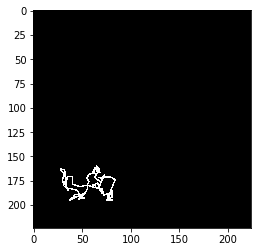

In [8]:
plt.imshow(dataset[25000].to("cpu").reshape(dataset[0].shape[1], dataset[0].shape[1]), cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

In [9]:
model_name = "ConvVAE_224"
img_size = dataset[0].shape[1]
model = ConvVAE_224(img_size).to(device)
print(model)

ConvVAE_224(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(7, 7), stride=(1, 1))
  (conv_mean): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (t_conv7): ConvTranspose2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (t_conv6): ConvTranspose2d(1024, 512, kernel_size=(7, 7), stride=(1, 1))
  (t_conv5): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  (t_conv4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64

In [10]:
def loss_function(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [11]:
optimizer = torch.optim.Adam(model.parameters())

In [12]:
num_save = 400
num_epochs = 1
train_ls = []

### 訓練

モデルの保存はCPUへ

In [ ]:
for n in range(num_save):
    if n == 325 :
        optimizer.defaults["lr"] = 0.0005
    if n == 375:
        optimizer.defaults["lr"] = 0.0001
    for epoch in range(num_epochs):
        
        t1 = time.time()
        loss_sum = 0.0
        for i, batch_imgs in enumerate(dataloader):
            optimizer.zero_grad()
            reconstructed_imgs, mu, logvar = model(batch_imgs.to(device))
            loss = loss_function(reconstructed_imgs, batch_imgs.to(device), mu, logvar)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        t2 = time.time()
        train_ls.append(loss_sum)

        print("epoch --- %d train_loss: %.3f (train time: %.1f s = %.1f min)" %(n * num_epochs + epoch + 1, loss_sum, t2 - t1, (t2 - t1) / 60))
    if n % 10 == 0:
        torch.save(model.state_dict(), "../model_pths/" + model_name + ".pth")
        with open("train_ls.pkl", "wb") as f:
            pickle.dump(train_ls, f)

epoch --- 1 train_loss: 71358731.898 (train time: 119.1 s = 2.0 min)
epoch --- 2 train_loss: 25779838.531 (train time: 107.8 s = 1.8 min)
epoch --- 3 train_loss: 24321540.406 (train time: 104.0 s = 1.7 min)
epoch --- 4 train_loss: 23374695.820 (train time: 103.4 s = 1.7 min)
epoch --- 5 train_loss: 22518378.016 (train time: 104.3 s = 1.7 min)
epoch --- 6 train_loss: 21692123.445 (train time: 104.6 s = 1.7 min)
epoch --- 7 train_loss: 20824012.707 (train time: 105.3 s = 1.8 min)
epoch --- 8 train_loss: 20072073.723 (train time: 105.3 s = 1.8 min)
epoch --- 9 train_loss: 19276990.004 (train time: 106.2 s = 1.8 min)
epoch --- 10 train_loss: 18506677.523 (train time: 105.4 s = 1.8 min)
epoch --- 11 train_loss: 17793459.430 (train time: 105.7 s = 1.8 min)
epoch --- 12 train_loss: 17180154.184 (train time: 105.7 s = 1.8 min)
epoch --- 13 train_loss: 16600982.883 (train time: 105.7 s = 1.8 min)
epoch --- 14 train_loss: 16012554.707 (train time: 106.0 s = 1.8 min)
epoch --- 15 train_loss: 1549

epoch --- 120 train_loss: 6768901.938 (train time: 105.8 s = 1.8 min)
epoch --- 121 train_loss: 6788156.922 (train time: 106.1 s = 1.8 min)
epoch --- 122 train_loss: 6769238.326 (train time: 105.4 s = 1.8 min)
epoch --- 123 train_loss: 6743893.262 (train time: 106.0 s = 1.8 min)
epoch --- 124 train_loss: 6739723.672 (train time: 105.4 s = 1.8 min)
epoch --- 125 train_loss: 6709130.922 (train time: 105.6 s = 1.8 min)
epoch --- 126 train_loss: 6695544.783 (train time: 105.5 s = 1.8 min)
epoch --- 127 train_loss: 6704803.096 (train time: 106.1 s = 1.8 min)
epoch --- 128 train_loss: 6667423.268 (train time: 105.9 s = 1.8 min)
epoch --- 129 train_loss: 6683625.301 (train time: 105.6 s = 1.8 min)
epoch --- 130 train_loss: 6629038.391 (train time: 105.9 s = 1.8 min)
epoch --- 131 train_loss: 6655753.314 (train time: 105.9 s = 1.8 min)
epoch --- 132 train_loss: 6662670.432 (train time: 106.2 s = 1.8 min)
epoch --- 133 train_loss: 6594157.281 (train time: 105.9 s = 1.8 min)
epoch --- 134 train_

In [ ]:
torch.save(model.state_dict(), "../model_pths/" + model_name + ".pth")
with open("train_ls.pkl", "wb") as f:
    pickle.dump(train_ls, f)

In [31]:
def plot_results(result, which_result, condition, save_or_not=True):
    plt.clf()
    plt.plot(result)
    plt.title(condition + "_" + which_result)
    plt.savefig(condition + "_" + which_result + ".png") if save_or_not else plt.show()

In [32]:
loss_img_path = "../loss_imgs/"
condition = "ConvVAE_224to64"

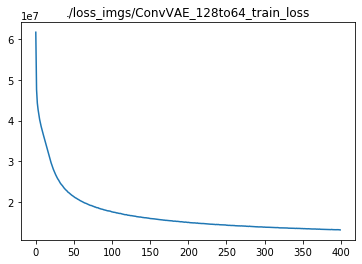

In [33]:
plot_results(train_ls, "train_loss", loss_img_path + condition)

In [34]:
poses = [1000,2000,3000,4000,5000,6000]

<Figure size 432x288 with 0 Axes>

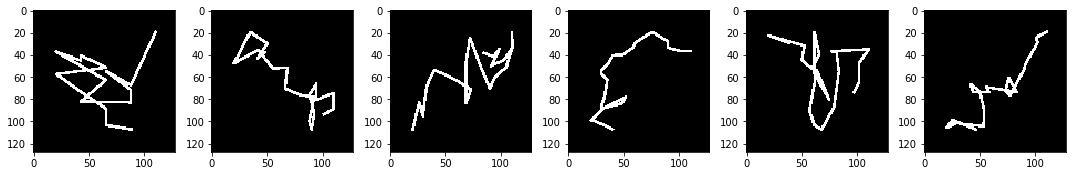

In [37]:
imshow_conv(dataset, poses)

<Figure size 432x288 with 0 Axes>

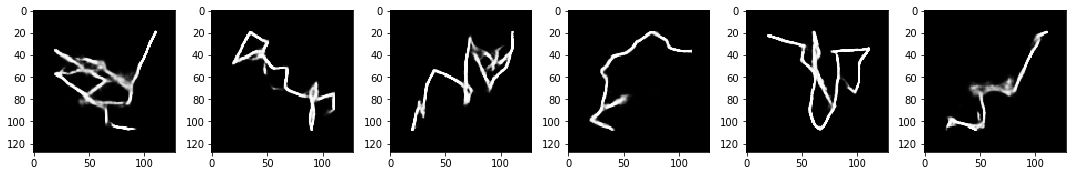

In [44]:
imshow_conv(dataset, poses, model=model, device=device)